In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, hour, unix_timestamp, date_format, when 
from pyspark.ml.feature import StringIndexer, OneHotEncoder,VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import dash
from dash import dcc
from dash import html
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Initialize Spark session
spark = SparkSession.builder.appName('AnomalyDetection').getOrCreate()

In [3]:
#Load the training and testing datasets
train_data = spark.read.csv('fraudTrain.csv', header=True, inferSchema=True)
test_data = spark.read.csv('fraudTest.csv', header=True, inferSchema=True)

In [4]:
#Preview the data
train_data.show(5)

+---+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|_c0|trans_date_trans_time|          cc_num|            merchant|     category|   amt|    first|   last|gender|              street|          city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat| merch_long|is_fraud|
+---+---------------------+----------------+--------------------+-------------+------+---------+-------+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+
|  0|  2019-01-01 00:00:18|2703186189652095|fraud_Rippin, Kub...|     misc_net|  4.97| Jennifer|  Banks|     F|      561 Perry 

In [5]:
train_data.columns

['_c0',
 'trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

In [6]:
train_data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [7]:
train_data.select('city_pop','job','dob').show(5)

+--------+--------------------+----------+
|city_pop|                 job|       dob|
+--------+--------------------+----------+
|    3495|Psychologist, cou...|1988-03-09|
|     149|Special education...|1978-06-21|
|    4154|Nature conservati...|1962-01-19|
|    1939|     Patent attorney|1967-01-12|
|      99|Dance movement ps...|1986-03-28|
+--------+--------------------+----------+
only showing top 5 rows



Data Preprocessing

In [8]:
#Convert 'trans_date_trans_time' to a proper timestamp and extract time-based features
train_data = train_data.withColumn('trans_date_trans_time', unix_timestamp(col('trans_date_trans_time')).cast('timestamp'))
train_data = train_data.withColumn('Hour', hour(col('trans_date_trans_time')))
train_data = train_data.withColumn('DayOfWeek', date_format(col('trans_date_trans_time'), 'E'))

test_data = test_data.withColumn('trans_date_trans_time', unix_timestamp(col('trans_date_trans_time')).cast('timestamp'))
test_data = test_data.withColumn('Hour', hour(col('trans_date_trans_time')))
test_data = test_data.withColumn('DayOfWeek', date_format(col('trans_date_trans_time'), 'E'))

In [9]:
#Handling missing values
train_data = train_data.fillna({'merchant': 'unknown', 'category': 'unknown', 'amt': 0, 'lat': 0, 'long': 0, 'merch_lat': 0, 'merch_long': 0})
test_data = test_data.fillna({'merchant': 'unknown', 'category': 'unknown', 'amt': 0, 'lat': 0, 'long': 0, 'merch_lat': 0, 'merch_long': 0})

In [10]:
#Distribution of fraud and non-fraud
gender_data = train_data.groupBy("gender").count().sort("count", ascending=False)
gender_data.show(10)

+------+------+
|gender| count|
+------+------+
|     F|709863|
|     M|586812|
+------+------+



<Axes: xlabel='gender'>

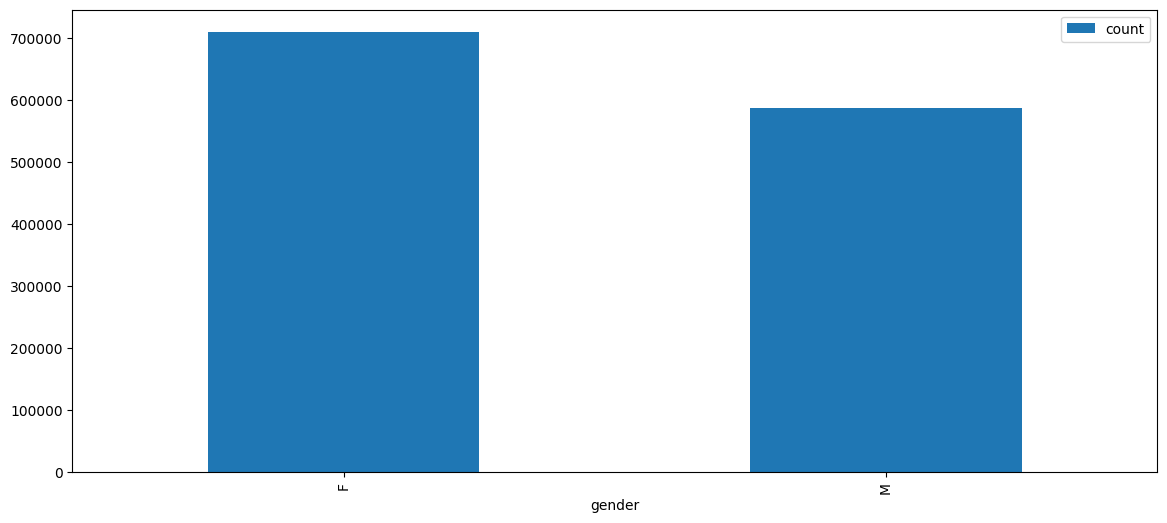

In [11]:
gender_data.toPandas().plot.bar(x='gender',figsize=(14, 6))

In [16]:
#Distribution of fraudulent to non fraudulent 
non_fraud_data = train_data.filter(col('is_fraud') == 1)
non_fraud_df = non_fraud_data.groupBy("is_fraud").count()
fraud_data = train_data.filter(col('is_fraud') == 0)
fraud_df = fraud_data.groupBy("is_fraud").count()
fraud_df.show()
non_fraud_df.show()

#Distribution based on gender
fraud_gender_df = train_data.groupBy("is_fraud", "gender").count()
fraud_gender_df.show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       0|1289169|
+--------+-------+

+--------+-----+
|is_fraud|count|
+--------+-----+
|       1| 7506|
+--------+-----+

+--------+------+------+
|is_fraud|gender| count|
+--------+------+------+
|       1|     F|  3735|
|       0|     M|583041|
|       1|     M|  3771|
|       0|     F|706128|
+--------+------+------+



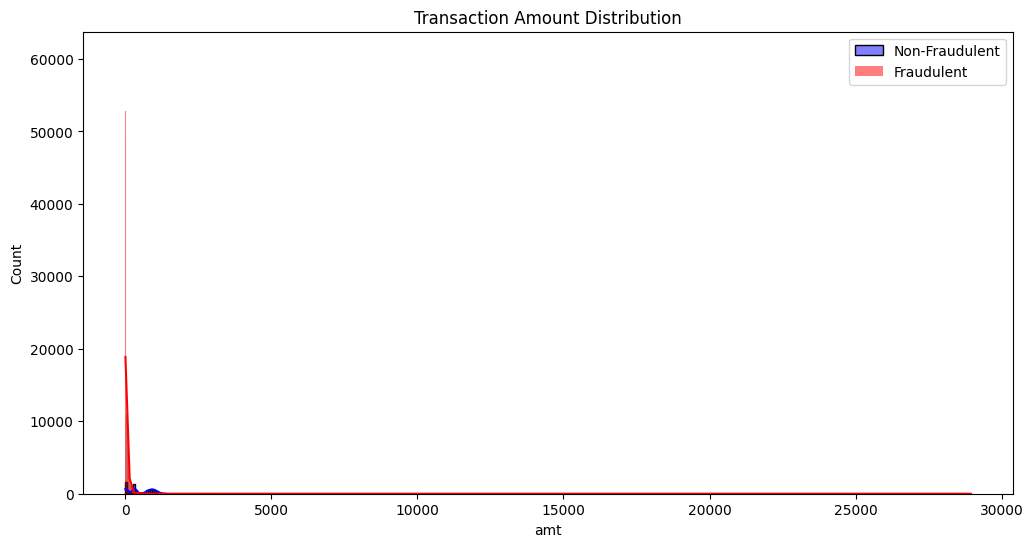

In [19]:
non_fraud_df = non_fraud_data.select('amt', 'Hour', 'DayOfWeek').toPandas()
fraud_df = fraud_data.select('amt', 'Hour', 'DayOfWeek').toPandas()

#Plot distributions of the transaction amounts
plt.figure(figsize=(12, 6))
sns.histplot(non_fraud_df['amt'], kde=True, color='blue', label='Non-Fraudulent')
sns.histplot(fraud_df['amt'], kde=True, color='red', label='Fraudulent')
plt.title('Transaction Amount Distribution')
plt.legend()
plt.show()


Statistical Inferences

In [20]:
po#summary statistics for the fraudulent transactions
fraud_stats = fraud_data.select('amt', 'Hour', 'city_pop', 'lat', 'long').describe()
fraud_stats.show()

#summary statistics for the non-fraudulent transactions
non_fraud_stats = non_fraud_data.select('amt', 'Hour' ,'city_pop', 'lat', 'long').describe()
non_fraud_stats.show()

+-------+------------------+------------------+-----------------+-----------------+------------------+
|summary|               amt|              Hour|         city_pop|              lat|              long|
+-------+------------------+------------------+-----------------+-----------------+------------------+
|  count|           1289169|           1289169|          1289169|          1289169|           1289169|
|   mean| 67.66710981260032|12.797678969941101|88775.22813688508|38.53688807425436|-90.22814202064717|
| stddev|154.00797054609956| 6.796796718026931|301806.5452038316|5.075234210755869|13.755982187702646|
|    min|               1.0|                 0|               23|          20.0271|         -165.6723|
|    max|           28948.9|                23|          2906700|          65.6899|          -67.9503|
+-------+------------------+------------------+-----------------+-----------------+------------------+

+-------+-----------------+------------------+-----------------+--------

Feature Engineering

In [21]:
#Encoding categorical features
indexer = StringIndexer(inputCols=['merchant', 'category', 'gender', 'state'], outputCols=['merchant_index', 'category_index', 'gender_index', 'state_index'])
indexer_model = indexer.fit(train_data)
train_data = indexer_model.transform(train_data)
test_data = indexer_model.transform(test_data)

encoder = OneHotEncoder(inputCols=['merchant_index', 'category_index', 'gender_index', 'state_index'], outputCols=['merchant_ohe', 'category_ohe', 'gender_ohe', 'state_ohe'])
encoder_model = encoder.fit(train_data)
train_data = encoder_model.transform(train_data)
test_data = encoder_model.transform(test_data)

train_data.show(10)
test_data.show(10)

+---+---------------------+----------------+--------------------+-------------+------+---------+--------+------+--------------------+--------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+----+---------+--------------+--------------+------------+-----------+-----------------+---------------+-------------+---------------+
|_c0|trans_date_trans_time|          cc_num|            merchant|     category|   amt|    first|    last|gender|              street|          city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat|        merch_long|is_fraud|Hour|DayOfWeek|merchant_index|category_index|gender_index|state_index|     merchant_ohe|   category_ohe|   gender_ohe|      state_ohe|
+---+---------------------+----------------+--------------------+-------------+------+---------+--------+------+----

In [22]:
featureCols = ['amt', 'Hour', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'merchant_ohe', 'category_ohe', 'gender_ohe', 'state_ohe']

In [23]:
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
train_assembled_df = assembler.transform(train_data)
train_assembled_df.show(10, truncate=False)

test_assembled_df = assembler.transform(test_data)
test_assembled_df.show(10, truncate=False)

+---+---------------------+----------------+----------------------------------+-------------+------+---------+--------+------+------------------------------+--------------+-----+-----+-------+------------------+--------+---------------------------------+----------+--------------------------------+----------+------------------+------------------+--------+----+---------+--------------+--------------+------------+-----------+-----------------+---------------+-------------+---------------+--------------------------------------------------------------------------------------------------------------------+
|_c0|trans_date_trans_time|cc_num          |merchant                          |category     |amt   |first    |last    |gender|street                        |city          |state|zip  |lat    |long              |city_pop|job                              |dob       |trans_num                       |unix_time |merch_lat         |merch_long        |is_fraud|Hour|DayOfWeek|merchant_index|catego

In [24]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scaler_model = scaler.fit(train_assembled_df)

train_scaled_df = scaler_model.transform(train_assembled_df)
test_scaled_df = scaler_model.transform(test_assembled_df)

In [25]:
# Final datasets 
train_data_df = train_scaled_df.select('scaledFeatures', 'is_fraud')
train_data_df.show(10, truncate=False)
test_data_df = test_scaled_df.select('scaledFeatures', 'is_fraud')
test_data_df.show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|scaledFeatures                                                                                                                                                                                                                     |is_fraud|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|(763,[0,2,3,4,5,6,578,710,712,725],[0.031001265028031362,7.1079908619447005,-5.899967004743803,0.011574520212218796,7.047511637406811,-5.958011430827895,32.00658769795707,4.641131313103782,2.0090660136313554,6.623178537103844])|0       |
|(763,[0,2,3,4,5,6,88,700,712,742],[0.668866

Model Creation

In [26]:
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='is_fraud', predictionCol='pred_is_fraud')

lr_model = lr.fit(train_data_df)

Model evaluation

In [31]:
predictions = lr_model.transform(test_data_df)

predictions.show(10, truncate = False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+----------------------------------------+-------------------------------------------+-------------+
|scaledFeatures                                                                                                                                                                                                                                          |is_fraud|rawPrediction                           |probability                                |pred_is_fraud|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+-----------------------

In [28]:
binary_evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')

auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
print(f"ROC AUC: {auc:.2f}")

ROC AUC: 0.81


In [32]:
app = dash.Dash(__name__)


app.layout = html.Div(children=[
    html.H1(children='Fraud Detection Dashboard'),

    dcc.Graph(
        id='amt-distribution',
        figure=px.histogram(non_fraud_df, x='amt', nbins=50, title='Non-Fraudulent Transaction Amounts').update_traces(marker_color='blue')
    ),
    dcc.Graph(
        id='fraud-amt-distribution',
        figure=px.histogram(fraud_df, x='amt', nbins=50, title='Fraudulent Transaction Amounts').update_traces(marker_color='red')
    )
])

if __name__ == '__main__':
    app.run_server(debug=True)
